# Dimensionality reduction analysis

In [1]:
%matplotlib inline

In [2]:
import os
import os.path as op

import numpy as np
import pandas as pd
from scipy import stats, spatial
from statsmodels.regression.linear_model import OLS

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
from nibabel.freesurfer import read_morph_data

from mayavi import mlab
from surfer import Brain, Surface

import moss
import lyman

In [3]:
os.environ["LYMAN_DIR"] = os.path.abspath("../lyman/")

In [4]:
from punch_utils import (residualize_roi_data, estimate_voxel_params, beeswarm,
                         load_real_mask, estimate_smoothness)

In [5]:
data_dir = lyman.gather_project_info()["data_dir"]
anal_dir = lyman.gather_project_info()["analysis_dir"]

In [6]:
os.environ["SUBJECTS_DIR"] = data_dir

In [7]:
sns.set(style="ticks", context="paper",
        rc={"xtick.major.size": 3, "ytick.major.size": 3,
            "xtick.major.width": 1, "ytick.major.width": 1,
            "xtick.major.pad": 3.5, "ytick.major.pad": 3.5,
            "axes.linewidth": 1, "lines.linewidth": 1})
mpl.rcParams["savefig.dpi"] = 150
pd.set_option("precision", 3)

In [8]:
subjects = pd.Series(np.loadtxt("subjects.txt", str), name="subj")

In [9]:
%load_ext rpy2.ipython
%R library(lme4)

/Users/mwaskom/anaconda/envs/punch/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: Matrix

  res = super(Function, self).__call__(*new_args, **new_kwargs)


array(['lme4', 'Matrix', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], 
      dtype='|S9')

In [10]:
%%R
lr.test = function(m1, m2, name){
    print(summary(m1))
    out = anova(m1, m2)
    chi2 = out$Chisq[2]
    dof = out$"Chi Df"[2]
    p = out$"Pr(>Chisq)"[2]
    test_str = "\nLikelihood ratio test for %s:\n  Chisq(%d) = %.2f; p = %.3g"
    writeLines(sprintf(test_str, name, dof, chi2, p))
}

In [11]:
rois = pd.Series(["IFS", "IPS", "mSPL", "PCC"], name="roi")

In [12]:
def savefig(fig, name):
    fig.savefig("figures/{}.pdf".format(name), dpi=120)
    fig.savefig("figures/{}.png".format(name), dpi=120)
    fig.savefig("tiffs/{}.tiff".format(name), dpi=300)

----

This notebook assumes that the ROI timecourse data has been cached. That can be accomplished with the following code

    rois = ['yeo17_ifs', 'yeo17_ips', 'yeo17_mspl', 'yeo17_pcc']
    import punch_utils
    punch_utils.cache_roi_timecourses(rois)

---

## Stability of context axis

Estimate the context axis on even/odd splits of the data, ask how similar the results are.

In [13]:
def compute_context_axis_similarity(roi):

    all_sim = pd.DataFrame(index=subjects, columns=["similarity"], dtype=np.float)
    for subj in subjects:

        data = residualize_roi_data(subj, "yeo17_" + roi.lower(), "task_rt_errors")
        
        runs = range(1, 13)
        conds = ["context"]

        even_data = data[::2]
        even_runs = runs[::2]
        even_params = estimate_voxel_params(subj, even_data,
                                            "context_single", even_runs, conds).T

        odd_data = data[1::2]
        odd_runs = runs[1::2]
        odd_params = estimate_voxel_params(subj, odd_data,
                                           "context_single", odd_runs, conds).T

        r, _ = stats.pearsonr(even_params["context"], odd_params["context"])
        all_sim.loc[subj] = r

    return all_sim

In [14]:
context_sims = {roi: compute_context_axis_similarity(roi.lower()) for roi in rois}
context_sim_long = pd.concat(context_sims, names=["roi", "subj"]).reset_index()

In [15]:
context_sim_long.to_csv("data/context_axis_similarity.csv", index=False)

In [16]:
context_sim_long.groupby("roi").mean().T

roi,IFS,IPS,PCC,mSPL
similarity,0.4,0.46,0.06,0.23


In [17]:
ttests = {roi: stats.ttest_1samp(data.similarity, 0) for roi, data in context_sims.items()}
pd.DataFrame(ttests, index=["t", "p"]).astype(object)

,IFS,IPS,PCC,mSPL
t,6.71,8.32,2.1,4.14
p,9.87e-06,8.64e-07,0.0542,0.000998


In [18]:
r, p = stats.pearsonr(context_sims["IFS"], context_sims["IPS"])
print "IFS - IPS context tuning stability correlation: r = {:.2f}, p = {:.2g}".format(r.item(), p.item())

IFS - IPS context tuning stability correlation: r = 0.81, p = 0.00028


---

## Invariance of context tuning to context cue

In [19]:
def compute_context_axis_similarity_across_cues(roi):

    all_sim = pd.DataFrame(index=subjects, columns=["similarity"], dtype=np.float)
    for subj in subjects:

        data = residualize_roi_data(subj, "yeo17_" + roi.lower(), "task_rt_errors")
        
        runs = range(1, 13)
        conds = ["context_0", "context_1"]

        even_data = data[::2]
        even_runs = runs[::2]
        even_params = estimate_voxel_params(subj, even_data,
                                            "context_single_by_frame", even_runs, conds).T

        odd_data = data[1::2]
        odd_runs = runs[1::2]
        odd_params = estimate_voxel_params(subj, odd_data,
                                           "context_single_by_frame", odd_runs, conds).T

        r_a, _ = stats.pearsonr(even_params["context_0"], odd_params["context_1"])
        r_b, _ = stats.pearsonr(odd_params["context_0"], even_params["context_1"])
        all_sim.loc[subj] = np.mean([r_a, r_b])

    return all_sim

In [20]:
context_sims_by_cue = {roi: compute_context_axis_similarity_across_cues(roi.lower()) for roi in rois[:2]}
context_sim_by_cue_long = pd.concat(context_sims_by_cue, names=["roi", "subj"]).reset_index()

In [21]:
context_sim_by_cue_long.groupby("roi").mean().T

roi,IFS,IPS
similarity,0.25,0.29


In [22]:
ttests = {roi: stats.ttest_1samp(data.similarity, 0) for roi, data in context_sims_by_cue.items()}
pd.DataFrame(ttests, index=["t", "p"]).astype(object)

,IFS,IPS
t,5.1,5.92
p,0.000163,3.76e-05


----

## Context separation as a function of CPE

Does the pattern distance along the context axis increase for trials with higher CPE?

In [23]:
def compute_context_separation(roi, resid_model="task_rt_errors"):
    
    all_proj = dict()
    for subj in subjects:
        
        data = residualize_roi_data(subj, "yeo17_" + roi.lower(), resid_model)
        runs = range(1, 13)
        conds = [context + "_" + i for i in "1234" for context in ["motion", "color"]]
        
        axis = estimate_voxel_params(subj, data, "context_single", runs, ["context"])
        axis = axis.values.ravel()
        axis = axis / np.linalg.norm(axis)
        
        params = estimate_voxel_params(subj, data, "cpe_quartiles_by_context", runs, conds)
        proj = pd.Series(axis.dot(params.T), name="proj", index=params.index)
        proj /= np.linalg.norm(params, axis=1)
        all_proj[subj] = proj

    proj = pd.concat(all_proj, names=["subj", "cond"]).reset_index(name="proj")
    proj["context"] = proj.cond.str[:-2]
    proj["cpe"] = proj.cond.str[-1].astype(int)

    return proj

In [24]:
def make_long_cpe_separation_df(rois, *args):

    cpe_projections = {roi: compute_context_separation(roi, *args) for roi in rois}
    cpe_projections = pd.concat(cpe_projections, names=["roi"]).reset_index("roi")
    cpe_proj = cpe_projections.set_index(["roi", "subj", "cpe", "context"])["proj"]
    cpe_separation = cpe_proj.unstack().eval("motion - color").reset_index(name="dist")
    cpe_separation = moss.remove_unit_variance(cpe_separation, "dist", "subj", "roi")
    return cpe_separation

In [25]:
cpe_separation = make_long_cpe_separation_df(["IFS", "IPS"])

In [26]:
cpe_separation.to_csv("data/cpe_separation.csv")

In [27]:
%R -i cpe_separation

In [28]:
%%R
m <- lmer(dist ~ cpe + (cpe | subj), cpe_separation, subset=roi=="IFS")
m.null <- lmer(dist ~ 1 + (cpe | subj), cpe_separation, subset=roi=="IFS")
lr.test(m, m.null, "main effect of CPE on IFS pattern distance")

/Users/mwaskom/anaconda/envs/punch/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: refitting model(s) with ML (instead of REML)

  res = super(Function, self).__call__(*new_args, **new_kwargs)


Linear mixed model fit by REML ['lmerMod']
Formula: dist ~ cpe + (cpe | subj)
   Data: cpe_separation
 Subset: roi == "IFS"

REML criterion at convergence: -1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.13306 -0.41667  0.00995  0.65250  1.88521 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr 
 subj     (Intercept) 0.0428530 0.20701       
          cpe         0.0002026 0.01424  -1.00
 Residual             0.0347939 0.18653       
Number of obs: 60, groups:  subj, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.42051    0.07960   5.283
cpe          0.19920    0.02185   9.117

Correlation of Fixed Effects:
    (Intr)
cpe -0.780

Likelihood ratio test for main effect of CPE on IFS pattern distance:
  Chisq(1) = 34.06; p = 5.34e-09


In [29]:
%%R
m <- lmer(dist ~ cpe + (cpe | subj), cpe_separation, subset=roi=="IPS")
m.null <- lmer(dist ~ 1 + (cpe | subj), cpe_separation, subset=roi=="IPS")
lr.test(m, m.null, "main effect of CPE on IPS pattern distance")

Linear mixed model fit by REML ['lmerMod']
Formula: dist ~ cpe + (cpe | subj)
   Data: cpe_separation
 Subset: roi == "IPS"

REML criterion at convergence: 11.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.9107 -0.5272  0.1857  0.5979  2.4678 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr
 subj     (Intercept) 0.0139368 0.11805      
          cpe         0.0001856 0.01362  1.00
 Residual             0.0474621 0.21786      
Number of obs: 60, groups:  subj, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.50812    0.07533   6.745
cpe          0.17495    0.02540   6.888

Correlation of Fixed Effects:
    (Intr)
cpe -0.771

Likelihood ratio test for main effect of CPE on IPS pattern distance:
  Chisq(1) = 25.94; p = 3.52e-07


---

### Controlling for task switches

In [30]:
cpe_separation_noswitch = make_long_cpe_separation_df(["IFS", "IPS"], "task_rt_errors_switch")

In [31]:
%R -i cpe_separation_noswitch

In [32]:
%%R
m <- lmer(dist ~ cpe + (cpe | subj), cpe_separation_noswitch, subset=roi=="IFS")
m.null <- lmer(dist ~ 1 + (cpe | subj), cpe_separation_noswitch, subset=roi=="IFS")
lr.test(m, m.null, "main effect of CPE on IFS pattern distance controlling for switches")

Linear mixed model fit by REML ['lmerMod']
Formula: dist ~ cpe + (cpe | subj)
   Data: cpe_separation_noswitch
 Subset: roi == "IFS"

REML criterion at convergence: -13.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2467 -0.5123  0.1609  0.5755  1.8701 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr 
 subj     (Intercept) 2.972e-02 0.172383      
          cpe         4.029e-05 0.006348 -1.00
 Residual             2.779e-02 0.166712      
Number of obs: 60, groups:  subj, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.22705    0.06900   3.291
cpe          0.25636    0.01932  13.269

Correlation of Fixed Effects:
    (Intr)
cpe -0.750

Likelihood ratio test for main effect of CPE on IFS pattern distance controlling for switches:
  Chisq(1) = 42.83; p = 5.97e-11


In [33]:
%%R
m <- lmer(dist ~ cpe + (cpe | subj), cpe_separation_noswitch, subset=roi=="IPS")
m.null <- lmer(dist ~ 1 + (cpe | subj), cpe_separation_noswitch, subset=roi=="IPS")
lr.test(m, m.null, "main effect of CPE on IPS pattern distance controlling for switches")

Linear mixed model fit by REML ['lmerMod']
Formula: dist ~ cpe + (cpe | subj)
   Data: cpe_separation_noswitch
 Subset: roi == "IPS"

REML criterion at convergence: 8.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1880 -0.5185  0.0564  0.5581  2.2108 

Random effects:
 Groups   Name        Variance  Std.Dev. Corr
 subj     (Intercept) 0.0066228 0.08138      
          cpe         0.0003652 0.01911  1.00
 Residual             0.0469589 0.21670      
Number of obs: 60, groups:  subj, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.29585    0.07168   4.128
cpe          0.24173    0.02550   9.478

Correlation of Fixed Effects:
    (Intr)
cpe -0.800

Likelihood ratio test for main effect of CPE on IPS pattern distance controlling for switches:
  Chisq(1) = 34.58; p = 4.09e-09


----

### Controling for differences in SNR

In [34]:
def compute_context_axis_similarity_by_cpe(roi):

    cpe_bins = pd.Series(range(1, 5), name="cpe")
    all_sim = pd.DataFrame(index=subjects,
                           columns=cpe_bins,
                           dtype=np.float)
    for subj in subjects:

        data = residualize_roi_data(subj, "yeo17_" + roi.lower(), "task_rt_errors")

        conds = ["cpe_{}".format(i) for i in cpe_bins]
        runs = range(1, 13)

        even_data = data[::2]
        even_runs = runs[::2]
        even_params = estimate_voxel_params(subj, even_data,
                                            "context_single_by_cpe_quartiles",
                                            even_runs, conds).T        
        odd_data = data[1::2]
        odd_runs = runs[1::2]
        odd_params = estimate_voxel_params(subj, odd_data,
                                           "context_single_by_cpe_quartiles",
                                           odd_runs, conds).T

        for cpe_bin in cpe_bins:
            bin_str = "cpe_{}".format(cpe_bin)
            r, _ = stats.pearsonr(even_params[bin_str], odd_params[bin_str])
            all_sim.loc[subj, cpe_bin] = r

    return all_sim

In [35]:
context_snr = {roi: compute_context_axis_similarity_by_cpe(roi) for roi in ["IFS", "IPS"]}
context_snr_long = pd.concat(context_snr, names=["roi"]).stack()

In [36]:
cpe_separation_backup = cpe_separation

In [37]:
cpe_separation_long = cpe_separation.set_index(["roi", "subj", "cpe"])
cpe_separation_long["snr"] = context_snr_long
cpe_separation = cpe_separation_long.reset_index()

In [38]:
%R -i cpe_separation

In [39]:
%%R
m <- lmer(dist ~ cpe + snr + (cpe + snr | subj), cpe_separation, subset=roi=="IFS")
m.null <- lmer(dist ~ snr + (cpe + snr | subj), cpe_separation, subset=roi=="IFS")
lr.test(m, m.null, "main effect of CPE on IFS pattern distance controlling for SNR")

Linear mixed model fit by REML ['lmerMod']
Formula: dist ~ cpe + snr + (cpe + snr | subj)
   Data: cpe_separation
 Subset: roi == "IFS"

REML criterion at convergence: -41.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9679 -0.6117  0.1089  0.7354  1.9687 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 subj     (Intercept) 0.030677 0.17515             
          cpe         0.002195 0.04685  -0.97      
          snr         0.014437 0.12015  -0.68  0.47
 Residual             0.019854 0.14090             
Number of obs: 60, groups:  subj, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.41551    0.06355   6.539
cpe          0.12926    0.02153   6.003
snr          1.38622    0.14299   9.694

Correlation of Fixed Effects:
    (Intr) cpe   
cpe -0.866       
snr -0.119 -0.269

Likelihood ratio test for main effect of CPE on IFS pattern distance controlling for SNR:
  Chisq(1) = 18.45; p = 1.74e-05


In [40]:
%%R
m <- lmer(dist ~ cpe + snr + (cpe + snr | subj), cpe_separation, subset=roi=="IPS")
m.null <- lmer(dist ~ snr + (cpe + snr | subj), cpe_separation, subset=roi=="IPS")
lr.test(m, m.null, "main effect of CPE on IPS pattern distance controlling for SNR")

Linear mixed model fit by REML ['lmerMod']
Formula: dist ~ cpe + snr + (cpe + snr | subj)
   Data: cpe_separation
 Subset: roi == "IPS"

REML criterion at convergence: -3.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3278 -0.4794  0.1111  0.5561  2.3288 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 subj     (Intercept) 0.004232 0.06505             
          cpe         0.001315 0.03626  -1.00      
          snr         0.064583 0.25413   1.00 -1.00
 Residual             0.045361 0.21298             
Number of obs: 60, groups:  subj, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)  0.45641    0.07050   6.474
cpe          0.11391    0.02865   3.976
snr          1.17273    0.22645   5.179

Correlation of Fixed Effects:
    (Intr) cpe   
cpe -0.784       
snr -0.059 -0.460

Likelihood ratio test for main effect of CPE on IPS pattern distance controlling for SNR:
  Chisq(1) = 9.99; p = 0.00157


---

## Main figure

In [41]:
def plot_dim_reduction_schematic(ax):

    rs = np.random.RandomState(88)
    c = np.repeat([1, -1], 10)
    X = np.c_[np.ones(20), c]
    v1 = X.dot([3, -1.5]) + rs.normal(0, 1, 20)
    v2 = X.dot([4, .5]) + rs.normal(0, 1, 20)
    
    ax.scatter(v1 - v1.mean(), v2 - v2.mean(), s=20,
               c=c, linewidths=1, vmax=1.3, edgecolor=".15")
    ax.set(xlim=(-4, 4), ylim=(-4, 4))

    coefs = OLS(np.c_[v1, v2], c).fit().params.ravel()
    anchors = np.transpose([coefs * [-10, -10], coefs * [10, 10]])
    ax.plot(*anchors, ls="--", c=".15", dashes=[3, 1.5])

    ax.plot([(v1 - v1.mean())[c == 1].mean()],
            [(v2 - v2.mean())[c == 1].mean()],
             "x", ms=9, mew=3, mec="w", c="w")
    ax.plot([(v1 - v1.mean())[c == 1].mean()],
            [(v2 - v2.mean())[c == 1].mean()],
            "x", ms=8, mew=1, mec=".15", c=".15")
    ax.plot([(v1 - v1.mean())[c == -1].mean()],
            [(v2 - v2.mean())[c == -1].mean()],
            "x", ms=9, mew=3, mec=".15", c=".15")
    ax.plot([(v1 - v1.mean())[c == -1].mean()],
            [(v2 - v2.mean())[c == -1].mean()],
            "x", ms=8, mew=1, mec="w", c="w")

    sns.despine(ax=ax, left=True, bottom=True)
    ax.set(xticks=[], yticks=[], aspect="equal")
    ax.axhline(0, lw=1, c=".15", zorder=0)
    ax.axvline(0, lw=1, c=".15", zorder=0)
    ax.text(-4, -.2, "Voxel 1", va="top", size=7)
    ax.text(.2, -4, "Voxel 2", rotation=90, va="bottom", size=7)


In [42]:
def plot_context_axis_similarity(ax):

    rs = np.random.RandomState(5)

    ax.set(xlim=(-.5, 3.5), ylim=(-.25, .81))
    
    for i, roi in enumerate(rois):

        y = context_sims[roi].values.flat
        beeswarm(y, x=i, xlim=(-.5, 3.5), s=20, color=".15", linewidths=.2, edgecolor="white")
        m = np.mean(y)
        ax.plot([i - .4, i + .4], [m, m], color=".15", lw=1, zorder=0)
        l, = ax.plot([i - .4, i + .4], [0, 0], ls=":", color=".3", lw=1, dashes=[1, 1], zorder=0)
        l.set_color(".3")

        ax.text(i, .83, roi, size=8, color=".15", va="bottom", ha="center")
        
    ax.set(xticks=range(4),
           xticklabels=[],
           xlabel="",
           ylabel="Split-half correlation (r)",
           xlim=(-.5, 3.5),
           ylim=(-.21, .84))
    sns.despine(ax=ax, bottom=True, trim=True)


In [43]:
def draw_cpe_separation_dist(axl, axr):

    sns.pointplot("cpe", "dist_within", data=cpe_separation.query("roi == 'IFS'"),
              color=".15", n_boot=10000, ax=axl)
    sns.pointplot("cpe", "dist_within", data=cpe_separation.query("roi == 'IPS'"),
                  color=".15", n_boot=10000, ax=axr)

    axl.set_ylabel("  Normalized distance\n  on context axis (a.u.)", labelpad=3)
    axl.set(ylim=(.54, 1.4), yticklabels=[.6] + [""] * 7 + [1.4],
                   xticklabels=["Low\nCPE", "", "", "High\nCPE"],
                   xlabel="")
    axr.set(ylabel="", yticklabels=[],
            ylim=(.54, 1.4),
            xticklabels=["Low\nCPE", "", "", "High\nCPE"],
            xlabel="")

    axl.text(1.5, 1.4, "IFS", size=9, color=".15", ha="center", va="center")
    axr.text(1.5, 1.4, "IPS", size=9, color=".15", ha="center", va="center")

    sns.despine(ax=axl, trim=True)
    sns.despine(ax=axr, left=True, trim=True)


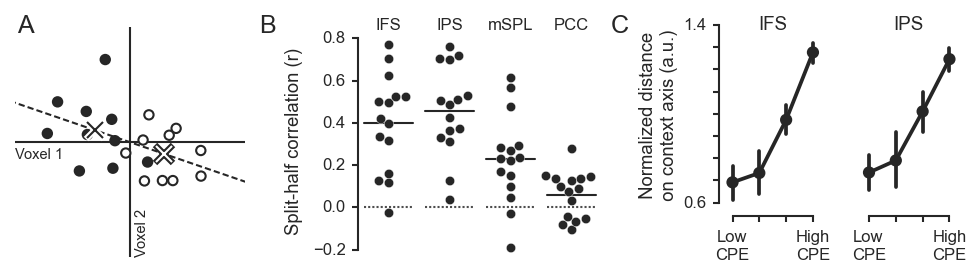

In [48]:
f = plt.figure(figsize=(6.5, 1.7))
ratio = 1.7 / 6.5

schem_ax = f.add_axes([.03 * ratio, .03, .9 * ratio, .9])
plot_dim_reduction_schematic(schem_ax)

# ---------------------------------------------------

with plt.rc_context({"xtick.major.size": 0}):
    sim_ax = f.add_axes([.36, .05, .25, .87])
plot_context_axis_similarity(sim_ax)

# ---------------------------------------------------

ifs_sep_ax = f.add_axes([.73, .19, .11, .75])
with plt.rc_context({"ytick.major.size": 0}):
    ips_sep_ax = f.add_axes([.87, .19, .11, .75])
draw_cpe_separation_dist(ifs_sep_ax, ips_sep_ax)

# ---------------------------------------------------

tkws = dict(size=12, color=".15")
f.text(.01, .91, "A", **tkws)
f.text(.26, .91, "B", **tkws)
f.text(.62, .91, "C", **tkws)

savefig(f, "dim_reduction_main")

----

## Spatial distribution of context tuning

In [46]:
def compute_voxel_tunings(roi, subjects):
    
    all_tune = dict()
    for subj in subjects:

        resid_data = residualize_roi_data(subj, "yeo17_" + roi.lower(), "task_rt_errors")
        context = estimate_voxel_params(subj, resid_data, "context_single", range(1, 13), ["context"])

        all_tune[subj] = pd.DataFrame(dict(context=context.values.flat))
        
    return pd.concat(all_tune, names=["subj", "voxel"]).reset_index()

In [47]:
def test_tuning_smoothness(roi, subjects):
    
    tunings = compute_voxel_tunings(roi, subjects)
    ps = []
    for subj in subjects:

        # Load the mask and find indices to the nearest neighbors at each voxel
        mask_data = load_real_mask(subj, "yeo17_" + roi.lower())
        mask_coords = np.argwhere(mask_data)
        kd = spatial.KDTree(mask_coords)
        neighbors = kd.query_ball_point(mask_coords, 2)

        # Compute the actual observed smoothness of the context tuning
        real_tunings = stats.zscore(tunings.query("subj == @subj").context)
        real_smoothness = estimate_smoothness(real_tunings, neighbors)

        # Generate a null distribution of smoothness
        null_tunings = np.load("permute_model/{}_{}_params.npy".format(subj, roi))
        null_dist = []
        for row in null_tunings:
            row = stats.zscore(row)
            smoothness = estimate_smoothness(row, neighbors)
            null_dist.append(smoothness)

        # Compute a p value and save to return
        ps.append(stats.percentileofscore(null_dist, real_smoothness))

    return np.array(ps)

In [48]:
for roi in ["IFS", "IPS"]:
    ps = test_tuning_smoothness(roi, subjects)
    print "{}: {}/15 subjects significant".format(roi, (ps < 5).sum())

IFS: 14/15 subjects significant
IPS: 13/15 subjects significant


---

## Supplemental figure

In [49]:
def surface_projection(subj, hemi, roi, values):

    # Get the coordinates of the graymid surface
    surf = Surface(subj, hemi, "white")
    surf.load_geometry()
    thick_file = op.join(data_dir, "{}/surf/{}.thickness".format(subj, hemi))
    thickness = read_morph_data(thick_file)
    verts = surf.coords + (surf.nn * (thickness * .5)[:, np.newaxis])
    verts4d = verts4d = np.c_[verts, np.ones(len(verts))].T

    # Load the ROI mask
    mask_file = op.join(data_dir, "{}/masks/yeo17_{}.nii.gz".format(subj, roi.lower()))
    mask = nib.load(mask_file)

    # Put the values into the volume
    vol = np.ones(mask.shape) * -200
    vol[mask.get_data().astype(bool)] = values
    
    # Load the epi to fs transformation
    xfm_file = op.join(anal_dir, "punch/{}/preproc/run_1/func2anat_tkreg.dat".format(subj))
    xfm = np.genfromtxt(xfm_file, skip_header=4, skip_footer=1)

    # Get the tkreg vox2ras matrix
    maskmgh = nib.MGHImage(mask.get_data(), mask.get_affine(), mask.get_header())
    affinv = np.linalg.inv(maskmgh.get_header().get_vox2ras_tkr())

    # Get the voxel coordinates
    i, j, k, _ = np.round(affinv.dot(xfm.dot(verts4d))).astype(int)

    # Get a mask to only use voxels coordinates in the field of view
    f = (k >= 0) & (k < 33)

    # Do the projection with sentinal values for out of the ROI
    overlay = np.ones_like(i, float) * -200
    overlay[f] = vol[i[f], j[f], k[f]]

    return overlay

In [50]:
def crop(arr):
    x, y = np.argwhere((arr != 255).any(axis=-1)).T
    return arr[x.min() - 2:x.max() + 2, y.min() - 2:y.max() + 2, :]

Set up colormap information

In [51]:
colormap = sns.diverging_palette(245, 20, 80, 40, n=256)
norm = mpl.colors.Normalize(vmin=-.25, vmax=.25)
cmap = mpl.colors.ListedColormap(colormap)
mapper = mpl.cm.ScalarMappable(norm, cmap)

Subjects to show in the supplemental figure

In [52]:
subj_subset = ["pc22", "pc12", "pc18", "pc07", "pc23"]

Tuning vectors to plot

In [53]:
tunings = compute_voxel_tunings("IFS", subj_subset)

In [54]:
cortex_maps = {subj: [] for subj in subj_subset}
for subj in subj_subset:
    subj_tuning = tunings.query("subj == @subj")
    for hemi in ["lh", "rh"]:
        overlay = surface_projection(subj, hemi, "ifs", subj_tuning.context)
        b = Brain(subj, hemi, "inflated", background="white", size=1000,
                  cortex=("gray", -2, 5, True))
        b.add_data(overlay, -.25, .25, -199, colormap, colorbar=False)
        mlab.view(*dict(lh=[135, 80], rh=[45, 80])[hemi])
        cortex_maps[subj].append(crop(b.screenshot()))
        b.close()

/Users/mwaskom/anaconda/envs/punch/lib/python2.7/site-packages/traits/has_traits.py:1766: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  setattr( self, name, value )


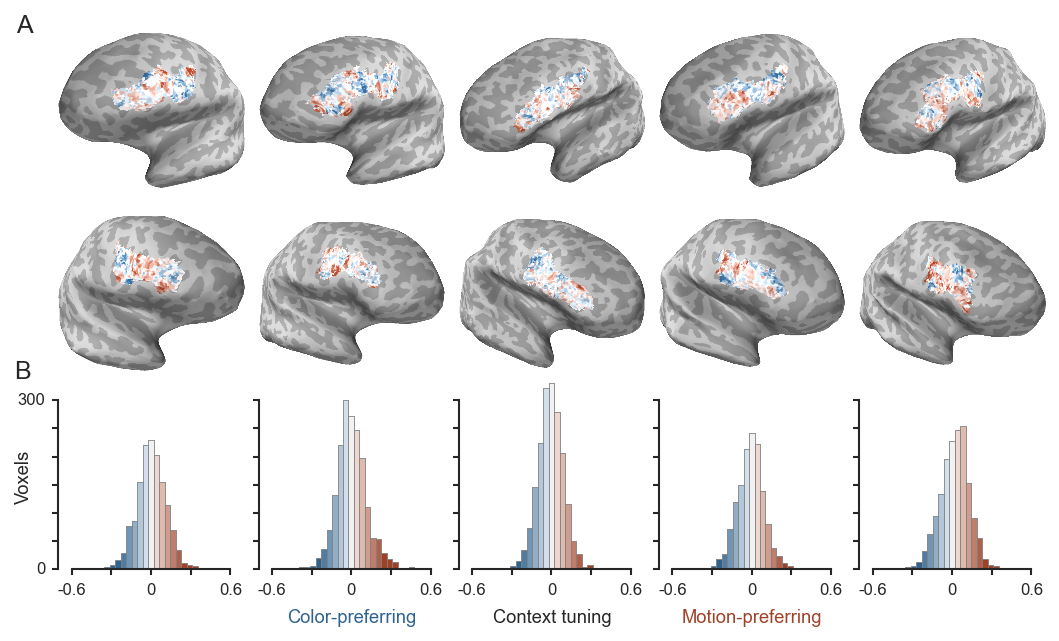

In [55]:
f, axes = plt.subplots(3, 5, figsize=(7, 4.2))

for i, subj in enumerate(subj_subset):

    subj_tuning = tunings.query("subj == @subj")

    # ---------------------------------------------------------------------------------- #
    for j, hemi in enumerate(["lh", "rh"]):
        overlay = surface_projection(subj, hemi, "ifs", subj_tuning.context)

        # Show the cortex screenshot on the axes
        brain_ax = axes[j, i]
        brain_ax.imshow(cortex_maps[subj][j], rasterized=True)
        brain_ax.set(xticks=[], yticks=[])
        brain_ax.set_axis_off()

    # ---------------------------------------------------------------------------------- #

    hist_ax = axes[2, i]

    # Compute and plot the histogram of context tuning values
    heights, bins = np.histogram(subj_tuning.context, bins=np.linspace(-.6, .6, 30))
    w = bins[1] - bins[0]
    c = mapper.to_rgba(bins + w / 2.)
    hist_ax.bar(bins[:-1], heights, w, color=c, lw=.4, ec=".5")
    hist_ax.set(xlim=(-.7, .7),
                xticks=[-.6, -.3, 0, .3, .6],
                xticklabels=[-.6, "", 0, "", .6],
                ylim=(0, 330),
                yticks=[0, 50, 100, 150, 200, 250, 300],
                yticklabels=[0, "", "", "", "", "", 300])

    if i:
        hist_ax.set_yticklabels([])
    else:
        hist_ax.set_ylabel("Voxels", labelpad=-7)
    if i == 2:
        hist_ax.set_xlabel("Context tuning")
    sns.despine(ax=hist_ax, trim=True)

# Add labels to the plot
axes[-1, 1].set_xlabel("Color-preferring", color=colormap[0])
axes[-1, 3].set_xlabel("Motion-preferring", color=colormap[-1])

f.text(.01, .96, "A", size=12, color=".15")
f.text(.01, .41, "B", size=12, color=".15")

f.tight_layout(pad=.5)
savefig(f, "dim_reduction_supplement")